In [1]:
# installing what we need for huggingface datasets and tools
!pip install --upgrade datasets transformers

***This first step is like going to the store to get our ingredients. We're installing the datasets library to easily download our text data and transformers to use efficient pre-trained models like DistilBERT.***

In [2]:
# pulling in the hf dataset tool
from datasets import load_dataset

dataset = load_dataset("tdavidson/hate_speech_offensive", download_mode='force_redownload') # 24k examples, label 0/1/2 = hate/offensive/neither

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

In this step, we loaded the “tdavidson/hate_speech_offensive” dataset by calling load_dataset(...). The line dataset = load_dataset("tdavidson/hate_speech_offensive") fetches and caches the tweets and their label field, giving us ready to use data for classification.

In [3]:
print(dataset['train'][0])  # tweet text + label

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import class_weight

# extract texts and labels from the HF dataset
texts = dataset['train']['tweet']      # list of all tweets
labels = dataset['train']['class']     # list of labels (0/1/2)


train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels       # preserves label distribution apparently
)


unique_classes = np.unique(train_labels)
weights = class_weight.compute_class_weight(
    class_weight='balanced', # 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
    classes=unique_classes,
    y=train_labels
)
# Create a dictionary mapping class index to its weight
class_weights_dict = dict(zip(unique_classes, weights))

print(f"\nCalculated class weights: {class_weights_dict}")
print(f"Dataset has classes: {dataset['train'].features['class'].names}")
print(f"Our label map will be: 0: Hate Speech, 1: Offensive Language, 2: Neither (based on dataset features)")

{'count': 3, 'hate_speech_count': 0, 'offensive_language_count': 0, 'neither_count': 3, 'class': 2, 'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."}

Calculated class weights: {np.int64(0): np.float64(5.776806526806527), np.int64(1): np.float64(0.4304759423310752), np.int64(2): np.float64(1.9845845845845846)}
Dataset has classes: ['hate speech', 'offensive language', 'neither']
Our label map will be: 0: Hate Speech, 1: Offensive Language, 2: Neither (based on dataset features)


***We're splitting our data into a training set (for the model to learn from) and a validation set (to check how well it's learning). Crucially, we've added code to calculate class_weights. This helps our model pay more attention to the "hate speech" class, which is less common in the data, so it doesn't get ignored.***

In [4]:
# bring in the tokenizer for distilbert
from transformers import DistilBertTokenizerFast  # hf tokenizer tool

# init tokenizer from pretrained weights
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")  # quick, lightweight and still performs as well as bert mostly

# tokenize our splits with uniform length
train_encodings = tokenizer(
    train_texts,
    truncation=True,            # chops longer tweets
    padding='max_length',       # pads shorter ones to max_length
    max_length=128              # cap sequences at 128 tokens
)
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=128
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

***We need to turn our text into numbers so we use tokenizer for this purpose. It converts tweets into sequences of numbers (tokens) and makes sure they're all the same length (128 here).***

In [5]:
import tensorflow as tf

# wrap encodings & labels into a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)) # inputs + targets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

train_dataset = train_dataset.shuffle(1000).batch(16)  # shuffle and batch the training set, just batch the validation set
val_dataset = val_dataset.batch(16)

***Here we converted our tokenized inputs and labels into tf.data.Dataset objects and applied shuffle(1000) with batch(16) for the training split, ensuring randomized batches, and simply batched the validation split for consistent evaluation.***

In [6]:
# bring in hf and tf
from transformers import TFDistilBertModel  # pretrained transformer
from tensorflow.keras import Model          # keras model assemble
from tensorflow.keras.layers import (
    Input,                                 # define inputs
    Lambda,                                # wrap for hf compatibility
    Dense,                                 # fully connected
    Dropout,                               # random unit drop
    BatchNormalization,                    # normalize activations
    LeakyReLU                             # Leaky ReLU activation
)
import tensorflow as tf                     # tf core
from tensorflow.keras.regularizers import l2

# load & freeze the pretrained base
base = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
base.trainable = False  # keep weights locked, we only train our custom head

# figure out hidden size for our pooled output
hidden_size = base.config.hidden_size  # usually 768

# define our two inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids") # 1D array of length 128
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask") #same here

# wrap hf model call so keras knows the output shape
# We take the embedding of the [CLS] token, which represents the whole sentence
pooled = Lambda(
    lambda ids_mask_tuple: base(input_ids=ids_mask_tuple[0], attention_mask=ids_mask_tuple[1])
                       .last_hidden_state[:, 0], # Use [CLS] token embedding
    output_shape=(hidden_size,)
)([input_ids, attention_mask]) # Pass inputs as a tuple


# layer 1- a bit wider to capture more features
x = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(pooled)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# layer 2- another layer for more complex patterns
x = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# layer 3- a smaller layer before the final decision, using 'swish' activation
x = Dense(32, activation="swish", kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(3, activation="softmax")(x) # output layer is 3 units for 3 classes (hate, offensive, neither), softmax for probabilities


model = Model(inputs=[input_ids, attention_mask], outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss="sparse_categorical_crossentropy", # Good for multi-class integer labels (0/1/2)
    metrics=["accuracy"] # we will look at more detailed metrics after training
)

model.summary()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    196,864 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,128 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │         99 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 235,651 (920.51 KB)

 Trainable params: 234,819 (917.26 KB)

 Non-trainable params: 832 (3.25 KB)

***Here i built the full model architecture by combining a frozen DistilBERT base with a custom classification head, which is pretty similar to what we did back in Week 5 when we froze VGG16 for image classification and just trained the dense layers we added on top.***

***I used TFDistilBertModel to extract features from the tweets, but I didn’t use the final output token predictions from the original model (jus
t like how we dropped VGG16’s top layer). I used a Lambda layer to grab the [CLS] token representation—the summary of each tweet—and passed that through my own head: a Dense → BatchNorm → Dropout → Softmax setup. Same structure as Week 5, just applied to text instead of images.***

***Freezing the base (base.trainable = False) is the same idea we did before: it lets us train faster and avoid messing up the pretrained knowledge, while still letting the new head learn task-specific features.***

In [8]:
# Install codecarbon if not already installed
!pip install codecarbon

from codecarbon import EmissionsTracker

# Start tracking emissions BEFORE training
tracker = EmissionsTracker(project_name="distilbert-hatespeech")
tracker.start()

# define a callback to stop if validation accuracy gets high
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy", 0) >= 0.92: # this target might need adjustment
            print(f"\nval_acc hit {logs['val_accuracy']:.2f}, stopping training!")
            self.model.stop_training = True

history = model.fit(
    train_dataset,                  # our shuffled/batched train data
    validation_data=val_dataset,    # the hold‑out set
    epochs=15,                      # max epochs
    callbacks=[mycallback()],       # attaching custom stopper
    verbose=1,                      # show loss & accuracy each epoch
    class_weight=class_weights_dict # this tells the model to pay more attention to minority classes (in this case its hatespeech mostly)
)

# Stop tracker and print emissions AFTER training
emissions = tracker.stop()
print(f"Training emissions: {emissions:.4f} kg CO₂")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.4/576.4 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take i

[codecarbon WARNING @ 12:43:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:43:49] [setup] RAM Tracking...
[codecarbon INFO @ 12:43:49] [setup] CPU Tracking...
[codecarbon WARNING @ 12:43:50] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:43:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 12:43:50] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 12:43:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:43:50] [setup] GPU Tracking...
[codecarbon INFO @ 12:43:50] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:43:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/15
 265/1240 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.4547 - loss: 1.2049

[codecarbon INFO @ 12:44:06] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:06] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 12:44:06] Energy consumed for all GPUs : 0.000284 kWh. Total GPU Power : 68.16055815946345 W
[codecarbon INFO @ 12:44:06] 0.000503 kWh of electricity used since the beginning.


 525/1240 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.4572 - loss: 1.1985

[codecarbon INFO @ 12:44:21] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:21] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:44:21] Energy consumed for all GPUs : 0.000569 kWh. Total GPU Power : 68.4426257581866 W
[codecarbon INFO @ 12:44:21] 0.001007 kWh of electricity used since the beginning.


 789/1240 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.4582 - loss: 1.2020

[codecarbon INFO @ 12:44:36] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:36] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 12:44:36] Energy consumed for all GPUs : 0.000855 kWh. Total GPU Power : 68.45077084129353 W
[codecarbon INFO @ 12:44:36] 0.001511 kWh of electricity used since the beginning.


1059/1240 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4606 - loss: 1.1959

[codecarbon INFO @ 12:44:51] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:44:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:51] Energy consumed for All CPU : 0.000708 kWh


1060/1240 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4606 - loss: 1.1959

[codecarbon INFO @ 12:44:51] Energy consumed for all GPUs : 0.001140 kWh. Total GPU Power : 68.530936394193 W
[codecarbon INFO @ 12:44:51] 0.002015 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4624 - loss: 1.1911

[codecarbon INFO @ 12:45:06] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:45:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:06] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 12:45:06] Energy consumed for all GPUs : 0.001398 kWh. Total GPU Power : 61.9154756865535 W
[codecarbon INFO @ 12:45:06] 0.002491 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:45:21] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:45:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:21] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 12:45:21] Energy consumed for all GPUs : 0.001681 kWh. Total GPU Power : 67.93075236193845 W
[codecarbon INFO @ 12:45:21] 0.002993 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 92s 74ms/step - accuracy: 0.4624 - loss: 1.1911 - val_accuracy: 0.5933 - val_loss: 1.0090
Epoch 2/15
 237/1240 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.4905 - loss: 1.0886

[codecarbon INFO @ 12:45:36] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:45:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:36] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 12:45:36] Energy consumed for all GPUs : 0.001960 kWh. Total GPU Power : 67.02077356362359 W
[codecarbon INFO @ 12:45:36] 0.003491 kWh of electricity used since the beginning.


 502/1240 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.4944 - loss: 1.1005

[codecarbon INFO @ 12:45:51] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:45:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:45:51] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 12:45:51] Energy consumed for all GPUs : 0.002245 kWh. Total GPU Power : 68.48784309095609 W
[codecarbon INFO @ 12:45:51] 0.003995 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:45:51] 0.015668 g.CO2eq/s mean an estimation of 494.1122102799047 kg.CO2eq/year


 770/1240 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.4965 - loss: 1.1016

[codecarbon INFO @ 12:46:06] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:46:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:06] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 12:46:06] Energy consumed for all GPUs : 0.002531 kWh. Total GPU Power : 68.50861949494457 W
[codecarbon INFO @ 12:46:06] 0.004499 kWh of electricity used since the beginning.


1036/1240 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.4985 - loss: 1.0991

[codecarbon INFO @ 12:46:21] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:46:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:21] Energy consumed for All CPU : 0.001770 kWh


1037/1240 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.4985 - loss: 1.0991

[codecarbon INFO @ 12:46:21] Energy consumed for all GPUs : 0.002816 kWh. Total GPU Power : 68.36769080943442 W
[codecarbon INFO @ 12:46:21] 0.005002 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4998 - loss: 1.0962

[codecarbon INFO @ 12:46:36] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:46:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:36] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 12:46:36] Energy consumed for all GPUs : 0.003101 kWh. Total GPU Power : 68.41201892438993 W
[codecarbon INFO @ 12:46:36] 0.005506 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 86s 70ms/step - accuracy: 0.4998 - loss: 1.0962 - val_accuracy: 0.5725 - val_loss: 1.0612
Epoch 3/15


[codecarbon INFO @ 12:46:51] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:46:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:51] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 12:46:51] Energy consumed for all GPUs : 0.003371 kWh. Total GPU Power : 64.92158309967945 W
[codecarbon INFO @ 12:46:51] 0.005995 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:06] Energy consumed for RAM : 0.000541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:47:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:06] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 12:47:06] Energy consumed for all GPUs : 0.003503 kWh. Total GPU Power : 31.74293475916621 W
[codecarbon INFO @ 12:47:06] 0.006346 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:21] Energy consumed for RAM : 0.000583 kWh. RAM Power : 1

 114/1240 ━━━━━━━━━━━━━━━━━━━━ 1:02 56ms/step - accuracy: 0.5500 - loss: 1.0165

[codecarbon INFO @ 12:47:51] Energy consumed for RAM : 0.000666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:47:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:47:51] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 12:47:51] Energy consumed for all GPUs : 0.003964 kWh. Total GPU Power : 47.170544502740945 W
[codecarbon INFO @ 12:47:51] 0.007463 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:47:51] 0.013604 g.CO2eq/s mean an estimation of 429.0026641516575 kg.CO2eq/year


 379/1240 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.5391 - loss: 1.0214

[codecarbon INFO @ 12:48:06] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:48:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:06] Energy consumed for All CPU : 0.003010 kWh
[codecarbon INFO @ 12:48:06] Energy consumed for all GPUs : 0.004251 kWh. Total GPU Power : 69.03142648414257 W
[codecarbon INFO @ 12:48:06] 0.007969 kWh of electricity used since the beginning.


 641/1240 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.5357 - loss: 1.0328

[codecarbon INFO @ 12:48:21] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:48:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:21] Energy consumed for All CPU : 0.003187 kWh
[codecarbon INFO @ 12:48:21] Energy consumed for all GPUs : 0.004538 kWh. Total GPU Power : 68.68777714967496 W
[codecarbon INFO @ 12:48:21] 0.008474 kWh of electricity used since the beginning.


 910/1240 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5357 - loss: 1.0373

[codecarbon INFO @ 12:48:36] Energy consumed for RAM : 0.000791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:48:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:36] Energy consumed for All CPU : 0.003364 kWh
[codecarbon INFO @ 12:48:36] Energy consumed for all GPUs : 0.004823 kWh. Total GPU Power : 68.59705962435191 W
[codecarbon INFO @ 12:48:36] 0.008978 kWh of electricity used since the beginning.


1182/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5364 - loss: 1.0383

[codecarbon INFO @ 12:48:51] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:48:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:48:51] Energy consumed for All CPU : 0.003541 kWh
[codecarbon INFO @ 12:48:51] Energy consumed for all GPUs : 0.005108 kWh. Total GPU Power : 68.38626736443412 W
[codecarbon INFO @ 12:48:51] 0.009482 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5365 - loss: 1.0382

[codecarbon INFO @ 12:49:06] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:49:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:49:06] Energy consumed for All CPU : 0.003718 kWh
[codecarbon INFO @ 12:49:06] Energy consumed for all GPUs : 0.005395 kWh. Total GPU Power : 68.7342164099603 W
[codecarbon INFO @ 12:49:06] 0.009987 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.5366 - loss: 1.0382 - val_accuracy: 0.6280 - val_loss: 0.9497
Epoch 4/15


[codecarbon INFO @ 12:49:21] Energy consumed for RAM : 0.000916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:49:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:49:21] Energy consumed for All CPU : 0.003895 kWh
[codecarbon INFO @ 12:49:21] Energy consumed for all GPUs : 0.005583 kWh. Total GPU Power : 45.1714809165885 W
[codecarbon INFO @ 12:49:21] 0.010394 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:36] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:49:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:49:36] Energy consumed for All CPU : 0.004072 kWh
[codecarbon INFO @ 12:49:36] Energy consumed for all GPUs : 0.005715 kWh. Total GPU Power : 31.611243181667948 W
[codecarbon INFO @ 12:49:36] 0.010744 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:49:51] Energy consumed for RAM : 0.001000 kWh. RAM Power : 1

 258/1240 ━━━━━━━━━━━━━━━━━━━━ 55s 56ms/step - accuracy: 0.5649 - loss: 0.9966

[codecarbon INFO @ 12:50:21] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:50:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:50:21] Energy consumed for All CPU : 0.004603 kWh
[codecarbon INFO @ 12:50:21] Energy consumed for all GPUs : 0.006260 kWh. Total GPU Power : 67.32249508394014 W
[codecarbon INFO @ 12:50:21] 0.011946 kWh of electricity used since the beginning.


 520/1240 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.5591 - loss: 1.0030

[codecarbon INFO @ 12:50:36] Energy consumed for RAM : 0.001125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:50:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:50:36] Energy consumed for All CPU : 0.004780 kWh
[codecarbon INFO @ 12:50:36] Energy consumed for all GPUs : 0.006547 kWh. Total GPU Power : 68.69943218898898 W
[codecarbon INFO @ 12:50:36] 0.012451 kWh of electricity used since the beginning.


 786/1240 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.5583 - loss: 1.0048

[codecarbon INFO @ 12:50:51] Energy consumed for RAM : 0.001166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:50:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:50:51] Energy consumed for All CPU : 0.004957 kWh
[codecarbon INFO @ 12:50:51] Energy consumed for all GPUs : 0.006833 kWh. Total GPU Power : 68.67032089228847 W
[codecarbon INFO @ 12:50:51] 0.012956 kWh of electricity used since the beginning.


1056/1240 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5584 - loss: 1.0063

[codecarbon INFO @ 12:51:06] Energy consumed for RAM : 0.001208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:51:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:51:06] Energy consumed for All CPU : 0.005134 kWh
[codecarbon INFO @ 12:51:06] Energy consumed for all GPUs : 0.007118 kWh. Total GPU Power : 68.3923208304761 W
[codecarbon INFO @ 12:51:06] 0.013459 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5585 - loss: 1.0057

[codecarbon INFO @ 12:51:21] Energy consumed for RAM : 0.001250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:51:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:51:21] Energy consumed for All CPU : 0.005311 kWh
[codecarbon INFO @ 12:51:21] Energy consumed for all GPUs : 0.007403 kWh. Total GPU Power : 68.52834307784376 W
[codecarbon INFO @ 12:51:21] 0.013964 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.5585 - loss: 1.0057 - val_accuracy: 0.6260 - val_loss: 0.9338
Epoch 5/15


[codecarbon INFO @ 12:51:36] Energy consumed for RAM : 0.001291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:51:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:51:36] Energy consumed for All CPU : 0.005488 kWh
[codecarbon INFO @ 12:51:36] Energy consumed for all GPUs : 0.007661 kWh. Total GPU Power : 61.79871809225737 W
[codecarbon INFO @ 12:51:36] 0.014440 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:51] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:51:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:51:51] Energy consumed for All CPU : 0.005665 kWh
[codecarbon INFO @ 12:51:51] Energy consumed for all GPUs : 0.007793 kWh. Total GPU Power : 31.717373833747292 W
[codecarbon INFO @ 12:51:51] 0.014790 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:51] 0.014493 g.CO2eq/s mean an estimation of 457.0567429

 135/1240 ━━━━━━━━━━━━━━━━━━━━ 1:01 56ms/step - accuracy: 0.5534 - loss: 1.0010

[codecarbon INFO @ 12:52:36] Energy consumed for RAM : 0.001458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:52:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:52:36] Energy consumed for All CPU : 0.006196 kWh
[codecarbon INFO @ 12:52:36] Energy consumed for all GPUs : 0.008267 kWh. Total GPU Power : 50.29302178675911 W
[codecarbon INFO @ 12:52:36] 0.015921 kWh of electricity used since the beginning.


 399/1240 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - accuracy: 0.5616 - loss: 0.9698

[codecarbon INFO @ 12:52:51] Energy consumed for RAM : 0.001499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:52:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:52:51] Energy consumed for All CPU : 0.006373 kWh
[codecarbon INFO @ 12:52:51] Energy consumed for all GPUs : 0.008553 kWh. Total GPU Power : 68.70246119432338 W
[codecarbon INFO @ 12:52:51] 0.016426 kWh of electricity used since the beginning.


 663/1240 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.5647 - loss: 0.9629

[codecarbon INFO @ 12:53:06] Energy consumed for RAM : 0.001541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:53:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:53:06] Energy consumed for All CPU : 0.006550 kWh
[codecarbon INFO @ 12:53:06] Energy consumed for all GPUs : 0.008840 kWh. Total GPU Power : 68.78852997557674 W
[codecarbon INFO @ 12:53:06] 0.016931 kWh of electricity used since the beginning.


 932/1240 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.5655 - loss: 0.9644

[codecarbon INFO @ 12:53:21] Energy consumed for RAM : 0.001583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:53:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:53:21] Energy consumed for All CPU : 0.006727 kWh
[codecarbon INFO @ 12:53:21] Energy consumed for all GPUs : 0.009127 kWh. Total GPU Power : 69.02860150460019 W
[codecarbon INFO @ 12:53:21] 0.017437 kWh of electricity used since the beginning.


1203/1240 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5665 - loss: 0.9642

[codecarbon INFO @ 12:53:36] Energy consumed for RAM : 0.001624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:53:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:53:36] Energy consumed for All CPU : 0.006904 kWh
[codecarbon INFO @ 12:53:36] Energy consumed for all GPUs : 0.009412 kWh. Total GPU Power : 68.38260528231345 W
[codecarbon INFO @ 12:53:36] 0.017940 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5667 - loss: 0.9642

[codecarbon INFO @ 12:53:51] Energy consumed for RAM : 0.001666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:53:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:53:51] Energy consumed for All CPU : 0.007081 kWh
[codecarbon INFO @ 12:53:51] Energy consumed for all GPUs : 0.009699 kWh. Total GPU Power : 68.87309436632604 W
[codecarbon INFO @ 12:53:51] 0.018446 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:51] 0.014339 g.CO2eq/s mean an estimation of 452.18393510834244 kg.CO2eq/year


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.5667 - loss: 0.9642 - val_accuracy: 0.6389 - val_loss: 0.9267
Epoch 6/15


[codecarbon INFO @ 12:54:06] Energy consumed for RAM : 0.001708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:54:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:54:06] Energy consumed for All CPU : 0.007258 kWh
[codecarbon INFO @ 12:54:06] Energy consumed for all GPUs : 0.009873 kWh. Total GPU Power : 41.78733788369863 W
[codecarbon INFO @ 12:54:06] 0.018838 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:54:21] Energy consumed for RAM : 0.001749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:54:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:54:21] Energy consumed for All CPU : 0.007435 kWh
[codecarbon INFO @ 12:54:21] Energy consumed for all GPUs : 0.010006 kWh. Total GPU Power : 31.858426851334798 W
[codecarbon INFO @ 12:54:21] 0.019189 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:54:36] Energy consumed for RAM : 0.001791 kWh. RAM Power : 

  11/1240 ━━━━━━━━━━━━━━━━━━━━ 1:15 61ms/step - accuracy: 0.6044 - loss: 0.8263

[codecarbon INFO @ 12:54:51] Energy consumed for RAM : 0.001833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:54:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:54:51] Energy consumed for All CPU : 0.007789 kWh
[codecarbon INFO @ 12:54:51] Energy consumed for all GPUs : 0.010278 kWh. Total GPU Power : 33.548441842690565 W
[codecarbon INFO @ 12:54:51] 0.019899 kWh of electricity used since the beginning.


 278/1240 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.5853 - loss: 0.9655

[codecarbon INFO @ 12:55:06] Energy consumed for RAM : 0.001874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:55:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:55:06] Energy consumed for All CPU : 0.007966 kWh
[codecarbon INFO @ 12:55:06] Energy consumed for all GPUs : 0.010563 kWh. Total GPU Power : 68.59873058572019 W
[codecarbon INFO @ 12:55:06] 0.020403 kWh of electricity used since the beginning.


 540/1240 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.5832 - loss: 0.9627

[codecarbon INFO @ 12:55:21] Energy consumed for RAM : 0.001916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:55:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:55:21] Energy consumed for All CPU : 0.008143 kWh
[codecarbon INFO @ 12:55:21] Energy consumed for all GPUs : 0.010850 kWh. Total GPU Power : 68.79765480304663 W
[codecarbon INFO @ 12:55:21] 0.020908 kWh of electricity used since the beginning.


 807/1240 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.5833 - loss: 0.9627

[codecarbon INFO @ 12:55:36] Energy consumed for RAM : 0.001957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:55:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:55:36] Energy consumed for All CPU : 0.008320 kWh
[codecarbon INFO @ 12:55:36] Energy consumed for all GPUs : 0.011135 kWh. Total GPU Power : 68.52424131178738 W
[codecarbon INFO @ 12:55:36] 0.021413 kWh of electricity used since the beginning.


1078/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5837 - loss: 0.9603

[codecarbon INFO @ 12:55:51] Energy consumed for RAM : 0.001999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:55:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:55:51] Energy consumed for All CPU : 0.008497 kWh
[codecarbon INFO @ 12:55:51] Energy consumed for all GPUs : 0.011420 kWh. Total GPU Power : 68.42863515159712 W
[codecarbon INFO @ 12:55:51] 0.021916 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:51] 0.013616 g.CO2eq/s mean an estimation of 429.3955418091954 kg.CO2eq/year


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5837 - loss: 0.9590

[codecarbon INFO @ 12:56:06] Energy consumed for RAM : 0.002041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:56:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:56:06] Energy consumed for All CPU : 0.008674 kWh
[codecarbon INFO @ 12:56:06] Energy consumed for all GPUs : 0.011708 kWh. Total GPU Power : 69.01304344136932 W
[codecarbon INFO @ 12:56:06] 0.022422 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.5837 - loss: 0.9590 - val_accuracy: 0.6571 - val_loss: 0.8829
Epoch 7/15


[codecarbon INFO @ 12:56:21] Energy consumed for RAM : 0.002082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:56:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:56:21] Energy consumed for All CPU : 0.008851 kWh
[codecarbon INFO @ 12:56:21] Energy consumed for all GPUs : 0.011949 kWh. Total GPU Power : 57.95583142374686 W
[codecarbon INFO @ 12:56:21] 0.022882 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:36] Energy consumed for RAM : 0.002124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:56:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:56:36] Energy consumed for All CPU : 0.009028 kWh
[codecarbon INFO @ 12:56:36] Energy consumed for all GPUs : 0.012082 kWh. Total GPU Power : 31.973460450792157 W
[codecarbon INFO @ 12:56:36] 0.023234 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:51] Energy consumed for RAM : 0.002166 kWh. RAM Power : 

 157/1240 ━━━━━━━━━━━━━━━━━━━━ 1:00 56ms/step - accuracy: 0.6040 - loss: 0.9097

[codecarbon INFO @ 12:57:21] Energy consumed for RAM : 0.002249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:57:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:57:21] Energy consumed for All CPU : 0.009559 kWh
[codecarbon INFO @ 12:57:21] Energy consumed for all GPUs : 0.012570 kWh. Total GPU Power : 53.46680699304889 W
[codecarbon INFO @ 12:57:21] 0.024378 kWh of electricity used since the beginning.


 421/1240 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - accuracy: 0.5977 - loss: 0.8995

[codecarbon INFO @ 12:57:36] Energy consumed for RAM : 0.002291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:57:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:57:36] Energy consumed for All CPU : 0.009736 kWh
[codecarbon INFO @ 12:57:36] Energy consumed for all GPUs : 0.012857 kWh. Total GPU Power : 68.7281874312306 W
[codecarbon INFO @ 12:57:36] 0.024883 kWh of electricity used since the beginning.


 685/1240 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.5962 - loss: 0.9014

[codecarbon INFO @ 12:57:51] Energy consumed for RAM : 0.002332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:57:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:57:51] Energy consumed for All CPU : 0.009913 kWh
[codecarbon INFO @ 12:57:51] Energy consumed for all GPUs : 0.013142 kWh. Total GPU Power : 68.59151586781745 W
[codecarbon INFO @ 12:57:51] 0.025387 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:51] 0.013617 g.CO2eq/s mean an estimation of 429.43281510003476 kg.CO2eq/year


 953/1240 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.5968 - loss: 0.9042

[codecarbon INFO @ 12:58:06] Energy consumed for RAM : 0.002374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:58:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:58:06] Energy consumed for All CPU : 0.010090 kWh
[codecarbon INFO @ 12:58:06] Energy consumed for all GPUs : 0.013428 kWh. Total GPU Power : 68.48359388957277 W
[codecarbon INFO @ 12:58:06] 0.025891 kWh of electricity used since the beginning.


1225/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5975 - loss: 0.9049

[codecarbon INFO @ 12:58:21] Energy consumed for RAM : 0.002416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:58:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:58:21] Energy consumed for All CPU : 0.010267 kWh
[codecarbon INFO @ 12:58:21] Energy consumed for all GPUs : 0.013713 kWh. Total GPU Power : 68.38816823642688 W
[codecarbon INFO @ 12:58:21] 0.026395 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5975 - loss: 0.9049

[codecarbon INFO @ 12:58:36] Energy consumed for RAM : 0.002457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:58:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:58:36] Energy consumed for All CPU : 0.010444 kWh
[codecarbon INFO @ 12:58:36] Energy consumed for all GPUs : 0.014002 kWh. Total GPU Power : 69.5169140591103 W
[codecarbon INFO @ 12:58:36] 0.026903 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.5975 - loss: 0.9049 - val_accuracy: 0.6770 - val_loss: 0.8530
Epoch 8/15


[codecarbon INFO @ 12:58:51] Energy consumed for RAM : 0.002499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:58:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:58:51] Energy consumed for All CPU : 0.010621 kWh
[codecarbon INFO @ 12:58:51] Energy consumed for all GPUs : 0.014163 kWh. Total GPU Power : 38.625647316545546 W
[codecarbon INFO @ 12:58:51] 0.027282 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:06] Energy consumed for RAM : 0.002540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:59:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:59:06] Energy consumed for All CPU : 0.010798 kWh
[codecarbon INFO @ 12:59:06] Energy consumed for all GPUs : 0.014295 kWh. Total GPU Power : 31.623775068186802 W
[codecarbon INFO @ 12:59:06] 0.027633 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:21] Energy consumed for RAM : 0.002582 kWh. RAM Power :

  33/1240 ━━━━━━━━━━━━━━━━━━━━ 1:09 58ms/step - accuracy: 0.6150 - loss: 0.8089

[codecarbon INFO @ 12:59:36] Energy consumed for RAM : 0.002624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:59:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:59:36] Energy consumed for All CPU : 0.011152 kWh
[codecarbon INFO @ 12:59:36] Energy consumed for all GPUs : 0.014579 kWh. Total GPU Power : 36.23850608702659 W
[codecarbon INFO @ 12:59:36] 0.028354 kWh of electricity used since the beginning.


 298/1240 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.6075 - loss: 0.8997

[codecarbon INFO @ 12:59:51] Energy consumed for RAM : 0.002665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 12:59:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:59:51] Energy consumed for All CPU : 0.011329 kWh
[codecarbon INFO @ 12:59:51] Energy consumed for all GPUs : 0.014864 kWh. Total GPU Power : 68.61030722512886 W
[codecarbon INFO @ 12:59:51] 0.028859 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:51] 0.013617 g.CO2eq/s mean an estimation of 429.42747493596625 kg.CO2eq/year


 559/1240 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.6028 - loss: 0.9112

[codecarbon INFO @ 13:00:06] Energy consumed for RAM : 0.002707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:00:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:00:06] Energy consumed for All CPU : 0.011506 kWh
[codecarbon INFO @ 13:00:06] Energy consumed for all GPUs : 0.015152 kWh. Total GPU Power : 69.12699062360073 W
[codecarbon INFO @ 13:00:06] 0.029365 kWh of electricity used since the beginning.


 826/1240 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.6023 - loss: 0.9158

[codecarbon INFO @ 13:00:21] Energy consumed for RAM : 0.002749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:00:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:00:21] Energy consumed for All CPU : 0.011683 kWh
[codecarbon INFO @ 13:00:21] Energy consumed for all GPUs : 0.015438 kWh. Total GPU Power : 68.53527866347788 W
[codecarbon INFO @ 13:00:21] 0.029869 kWh of electricity used since the beginning.


1096/1240 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6024 - loss: 0.9159

[codecarbon INFO @ 13:00:36] Energy consumed for RAM : 0.002790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:00:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:00:36] Energy consumed for All CPU : 0.011860 kWh
[codecarbon INFO @ 13:00:36] Energy consumed for all GPUs : 0.015723 kWh. Total GPU Power : 68.40174732497927 W
[codecarbon INFO @ 13:00:36] 0.030373 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6027 - loss: 0.9151

[codecarbon INFO @ 13:00:51] Energy consumed for RAM : 0.002832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:00:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:00:51] Energy consumed for All CPU : 0.012037 kWh
[codecarbon INFO @ 13:00:51] Energy consumed for all GPUs : 0.016008 kWh. Total GPU Power : 68.56293858044423 W
[codecarbon INFO @ 13:00:51] 0.030877 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.6027 - loss: 0.9151 - val_accuracy: 0.6581 - val_loss: 0.8799
Epoch 9/15


[codecarbon INFO @ 13:01:06] Energy consumed for RAM : 0.002874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:01:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:01:06] Energy consumed for All CPU : 0.012214 kWh
[codecarbon INFO @ 13:01:06] Energy consumed for all GPUs : 0.016246 kWh. Total GPU Power : 56.96104873954784 W
[codecarbon INFO @ 13:01:06] 0.031333 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:21] Energy consumed for RAM : 0.002915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:01:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:01:21] Energy consumed for All CPU : 0.012391 kWh
[codecarbon INFO @ 13:01:21] Energy consumed for all GPUs : 0.016378 kWh. Total GPU Power : 31.730556126566576 W
[codecarbon INFO @ 13:01:21] 0.031684 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:36] Energy consumed for RAM : 0.002957 kWh. RAM Power : 

 178/1240 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.6298 - loss: 0.8760

[codecarbon INFO @ 13:02:06] Energy consumed for RAM : 0.003040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:02:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:02:06] Energy consumed for All CPU : 0.012922 kWh
[codecarbon INFO @ 13:02:06] Energy consumed for all GPUs : 0.016878 kWh. Total GPU Power : 56.299225856336 W
[codecarbon INFO @ 13:02:06] 0.032840 kWh of electricity used since the beginning.


 440/1240 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.6226 - loss: 0.8914

[codecarbon INFO @ 13:02:21] Energy consumed for RAM : 0.003082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:02:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:02:21] Energy consumed for All CPU : 0.013099 kWh
[codecarbon INFO @ 13:02:21] Energy consumed for all GPUs : 0.017164 kWh. Total GPU Power : 68.6364285182424 W
[codecarbon INFO @ 13:02:21] 0.033345 kWh of electricity used since the beginning.


 704/1240 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.6195 - loss: 0.8972

[codecarbon INFO @ 13:02:36] Energy consumed for RAM : 0.003124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:02:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:02:36] Energy consumed for All CPU : 0.013276 kWh
[codecarbon INFO @ 13:02:36] Energy consumed for all GPUs : 0.017450 kWh. Total GPU Power : 68.51884206382712 W
[codecarbon INFO @ 13:02:36] 0.033849 kWh of electricity used since the beginning.


 971/1240 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.6178 - loss: 0.9004

[codecarbon INFO @ 13:02:51] Energy consumed for RAM : 0.003165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:02:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:02:51] Energy consumed for All CPU : 0.013453 kWh
[codecarbon INFO @ 13:02:51] Energy consumed for all GPUs : 0.017736 kWh. Total GPU Power : 68.76133450048 W
[codecarbon INFO @ 13:02:51] 0.034354 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6166 - loss: 0.9009

[codecarbon INFO @ 13:03:06] Energy consumed for RAM : 0.003207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:03:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:03:06] Energy consumed for All CPU : 0.013630 kWh
[codecarbon INFO @ 13:03:06] Energy consumed for all GPUs : 0.018021 kWh. Total GPU Power : 68.35881832971744 W
[codecarbon INFO @ 13:03:06] 0.034857 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:21] Energy consumed for RAM : 0.003248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:03:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:03:21] Energy consumed for All CPU : 0.013807 kWh
[codecarbon INFO @ 13:03:21] Energy consumed for all GPUs : 0.018307 kWh. Total GPU Power : 68.85460117193492 W
[codecarbon INFO @ 13:03:21] 0.035363 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.6166 - loss: 0.9009 - val_accuracy: 0.6607 - val_loss: 0.8619
Epoch 10/15


[codecarbon INFO @ 13:03:36] Energy consumed for RAM : 0.003290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:03:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:03:36] Energy consumed for All CPU : 0.013984 kWh
[codecarbon INFO @ 13:03:36] Energy consumed for all GPUs : 0.018463 kWh. Total GPU Power : 37.26749845178719 W
[codecarbon INFO @ 13:03:36] 0.035737 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:51] Energy consumed for RAM : 0.003332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:03:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:03:51] Energy consumed for All CPU : 0.014161 kWh
[codecarbon INFO @ 13:03:51] Energy consumed for all GPUs : 0.018595 kWh. Total GPU Power : 31.88511459612959 W
[codecarbon INFO @ 13:03:51] 0.036088 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:51] 0.014518 g.CO2eq/s mean an estimation of 457.83439452

  54/1240 ━━━━━━━━━━━━━━━━━━━━ 1:07 57ms/step - accuracy: 0.5696 - loss: 0.8180

[codecarbon INFO @ 13:04:21] Energy consumed for RAM : 0.003415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:04:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:04:21] Energy consumed for All CPU : 0.014515 kWh
[codecarbon INFO @ 13:04:21] Energy consumed for all GPUs : 0.018893 kWh. Total GPU Power : 39.59459003147298 W
[codecarbon INFO @ 13:04:21] 0.036823 kWh of electricity used since the beginning.


 316/1240 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.6027 - loss: 0.8809

[codecarbon INFO @ 13:04:36] Energy consumed for RAM : 0.003457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:04:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:04:36] Energy consumed for All CPU : 0.014692 kWh
[codecarbon INFO @ 13:04:36] Energy consumed for all GPUs : 0.019178 kWh. Total GPU Power : 68.54751051187752 W
[codecarbon INFO @ 13:04:36] 0.037327 kWh of electricity used since the beginning.


 574/1240 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.6081 - loss: 0.8795

[codecarbon INFO @ 13:04:51] Energy consumed for RAM : 0.003498 kWh. RAM Power : 10.0 W


 575/1240 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.6081 - loss: 0.8795

[codecarbon INFO @ 13:04:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:04:51] Energy consumed for All CPU : 0.014869 kWh
[codecarbon INFO @ 13:04:51] Energy consumed for all GPUs : 0.019464 kWh. Total GPU Power : 68.4425199832351 W
[codecarbon INFO @ 13:04:51] 0.037831 kWh of electricity used since the beginning.


 837/1240 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.6122 - loss: 0.8826

[codecarbon INFO @ 13:05:06] Energy consumed for RAM : 0.003540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:05:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:05:06] Energy consumed for All CPU : 0.015046 kWh
[codecarbon INFO @ 13:05:06] Energy consumed for all GPUs : 0.019748 kWh. Total GPU Power : 68.3054520834504 W
[codecarbon INFO @ 13:05:06] 0.038334 kWh of electricity used since the beginning.


1102/1240 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6148 - loss: 0.8819

[codecarbon INFO @ 13:05:21] Energy consumed for RAM : 0.003582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:05:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:05:21] Energy consumed for All CPU : 0.015223 kWh
[codecarbon INFO @ 13:05:21] Energy consumed for all GPUs : 0.020032 kWh. Total GPU Power : 68.30464555578075 W
[codecarbon INFO @ 13:05:21] 0.038837 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6156 - loss: 0.8812

[codecarbon INFO @ 13:05:36] Energy consumed for RAM : 0.003623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:05:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:05:36] Energy consumed for All CPU : 0.015400 kWh
[codecarbon INFO @ 13:05:36] Energy consumed for all GPUs : 0.020320 kWh. Total GPU Power : 69.02883347893007 W
[codecarbon INFO @ 13:05:36] 0.039343 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.6156 - loss: 0.8812 - val_accuracy: 0.6702 - val_loss: 0.8405
Epoch 11/15
 106/1240 ━━━━━━━━━━━━━━━━━━━━ 1:03 56ms/step - accuracy: 0.6427 - loss: 0.9000

[codecarbon INFO @ 13:05:51] Energy consumed for RAM : 0.003665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:05:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:05:51] Energy consumed for All CPU : 0.015577 kWh
[codecarbon INFO @ 13:05:51] Energy consumed for all GPUs : 0.020607 kWh. Total GPU Power : 68.86978627546762 W
[codecarbon INFO @ 13:05:51] 0.039849 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:51] 0.014752 g.CO2eq/s mean an estimation of 465.2293442789058 kg.CO2eq/year


 374/1240 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.6327 - loss: 0.8733

[codecarbon INFO @ 13:06:06] Energy consumed for RAM : 0.003707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:06:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:06:06] Energy consumed for All CPU : 0.015754 kWh
[codecarbon INFO @ 13:06:06] Energy consumed for all GPUs : 0.020892 kWh. Total GPU Power : 68.45606904092993 W
[codecarbon INFO @ 13:06:06] 0.040353 kWh of electricity used since the beginning.


 641/1240 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.6305 - loss: 0.8712

[codecarbon INFO @ 13:06:21] Energy consumed for RAM : 0.003748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:06:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:06:21] Energy consumed for All CPU : 0.015931 kWh
[codecarbon INFO @ 13:06:21] Energy consumed for all GPUs : 0.021177 kWh. Total GPU Power : 68.54312776242342 W
[codecarbon INFO @ 13:06:21] 0.040856 kWh of electricity used since the beginning.


 910/1240 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.6295 - loss: 0.8718

[codecarbon INFO @ 13:06:36] Energy consumed for RAM : 0.003790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:06:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:06:36] Energy consumed for All CPU : 0.016108 kWh
[codecarbon INFO @ 13:06:36] Energy consumed for all GPUs : 0.021463 kWh. Total GPU Power : 68.51005615815966 W
[codecarbon INFO @ 13:06:36] 0.041361 kWh of electricity used since the beginning.


1179/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6288 - loss: 0.8706

[codecarbon INFO @ 13:06:51] Energy consumed for RAM : 0.003831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:06:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:06:51] Energy consumed for All CPU : 0.016285 kWh
[codecarbon INFO @ 13:06:51] Energy consumed for all GPUs : 0.021748 kWh. Total GPU Power : 68.43053925683252 W
[codecarbon INFO @ 13:06:51] 0.041864 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6288 - loss: 0.8700

[codecarbon INFO @ 13:07:06] Energy consumed for RAM : 0.003873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:07:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:07:06] Energy consumed for All CPU : 0.016462 kWh
[codecarbon INFO @ 13:07:06] Energy consumed for all GPUs : 0.022037 kWh. Total GPU Power : 69.49863657033828 W
[codecarbon INFO @ 13:07:06] 0.042372 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6288 - loss: 0.8700 - val_accuracy: 0.6619 - val_loss: 0.8517
Epoch 12/15
 182/1240 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.6162 - loss: 0.8804

[codecarbon INFO @ 13:07:21] Energy consumed for RAM : 0.003915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:07:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:07:21] Energy consumed for All CPU : 0.016639 kWh
[codecarbon INFO @ 13:07:21] Energy consumed for all GPUs : 0.022323 kWh. Total GPU Power : 68.62158293261865 W
[codecarbon INFO @ 13:07:21] 0.042877 kWh of electricity used since the beginning.


 452/1240 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.6275 - loss: 0.8663

[codecarbon INFO @ 13:07:36] Energy consumed for RAM : 0.003956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:07:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:07:36] Energy consumed for All CPU : 0.016816 kWh
[codecarbon INFO @ 13:07:36] Energy consumed for all GPUs : 0.022608 kWh. Total GPU Power : 68.43815715396714 W
[codecarbon INFO @ 13:07:36] 0.043381 kWh of electricity used since the beginning.


 720/1240 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.6310 - loss: 0.8626

[codecarbon INFO @ 13:07:51] Energy consumed for RAM : 0.003998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:07:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:07:51] Energy consumed for All CPU : 0.016993 kWh
[codecarbon INFO @ 13:07:51] Energy consumed for all GPUs : 0.022893 kWh. Total GPU Power : 68.46921883854469 W
[codecarbon INFO @ 13:07:51] 0.043885 kWh of electricity used since the beginning.


 721/1240 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.6310 - loss: 0.8626

[codecarbon INFO @ 13:07:51] 0.015832 g.CO2eq/s mean an estimation of 499.28138452476577 kg.CO2eq/year


 990/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6327 - loss: 0.8581

[codecarbon INFO @ 13:08:06] Energy consumed for RAM : 0.004040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:08:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:08:06] Energy consumed for All CPU : 0.017170 kWh
[codecarbon INFO @ 13:08:06] Energy consumed for all GPUs : 0.023179 kWh. Total GPU Power : 68.51742072959377 W
[codecarbon INFO @ 13:08:06] 0.044389 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6338 - loss: 0.8557

[codecarbon INFO @ 13:08:21] Energy consumed for RAM : 0.004081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:08:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:08:21] Energy consumed for All CPU : 0.017347 kWh
[codecarbon INFO @ 13:08:21] Energy consumed for all GPUs : 0.023466 kWh. Total GPU Power : 68.88633175709438 W
[codecarbon INFO @ 13:08:21] 0.044895 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:08:36] Energy consumed for RAM : 0.004123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:08:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:08:36] Energy consumed for All CPU : 0.017524 kWh
[codecarbon INFO @ 13:08:36] Energy consumed for all GPUs : 0.023755 kWh. Total GPU Power : 69.41156948349591 W
[codecarbon INFO @ 13:08:36] 0.045402 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6338 - loss: 0.8557 - val_accuracy: 0.6911 - val_loss: 0.8096
Epoch 13/15
 261/1240 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.6559 - loss: 0.8674

[codecarbon INFO @ 13:08:51] Energy consumed for RAM : 0.004165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:08:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:08:51] Energy consumed for All CPU : 0.017701 kWh


 262/1240 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.6559 - loss: 0.8674

[codecarbon INFO @ 13:08:51] Energy consumed for all GPUs : 0.024041 kWh. Total GPU Power : 68.5432629862464 W
[codecarbon INFO @ 13:08:51] 0.045906 kWh of electricity used since the beginning.


 530/1240 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.6509 - loss: 0.8581

[codecarbon INFO @ 13:09:06] Energy consumed for RAM : 0.004206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:09:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:09:06] Energy consumed for All CPU : 0.017878 kWh
[codecarbon INFO @ 13:09:06] Energy consumed for all GPUs : 0.024326 kWh. Total GPU Power : 68.43879938828708 W
[codecarbon INFO @ 13:09:06] 0.046410 kWh of electricity used since the beginning.


 797/1240 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6500 - loss: 0.8565

[codecarbon INFO @ 13:09:21] Energy consumed for RAM : 0.004248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:09:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:09:21] Energy consumed for All CPU : 0.018055 kWh
[codecarbon INFO @ 13:09:21] Energy consumed for all GPUs : 0.024612 kWh. Total GPU Power : 68.76655362879058 W
[codecarbon INFO @ 13:09:21] 0.046915 kWh of electricity used since the beginning.


1065/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6496 - loss: 0.8524

[codecarbon INFO @ 13:09:36] Energy consumed for RAM : 0.004290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:09:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:09:36] Energy consumed for All CPU : 0.018232 kWh
[codecarbon INFO @ 13:09:36] Energy consumed for all GPUs : 0.024897 kWh. Total GPU Power : 68.35736739763256 W
[codecarbon INFO @ 13:09:36] 0.047419 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6495 - loss: 0.8504

[codecarbon INFO @ 13:09:51] Energy consumed for RAM : 0.004331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:09:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:09:51] Energy consumed for All CPU : 0.018409 kWh
[codecarbon INFO @ 13:09:51] Energy consumed for all GPUs : 0.025183 kWh. Total GPU Power : 68.77121806768038 W
[codecarbon INFO @ 13:09:51] 0.047924 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:09:51] 0.015845 g.CO2eq/s mean an estimation of 499.6891556828619 kg.CO2eq/year


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.6495 - loss: 0.8504 - val_accuracy: 0.6944 - val_loss: 0.8027
Epoch 14/15


[codecarbon INFO @ 13:10:06] Energy consumed for RAM : 0.004373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:10:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:10:06] Energy consumed for All CPU : 0.018586 kWh
[codecarbon INFO @ 13:10:06] Energy consumed for all GPUs : 0.025440 kWh. Total GPU Power : 61.68636882595909 W
[codecarbon INFO @ 13:10:06] 0.048400 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:10:21] Energy consumed for RAM : 0.004415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:10:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:10:21] Energy consumed for All CPU : 0.018763 kWh
[codecarbon INFO @ 13:10:21] Energy consumed for all GPUs : 0.025572 kWh. Total GPU Power : 31.674058771929523 W
[codecarbon INFO @ 13:10:21] 0.048750 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:10:36] Energy consumed for RAM : 0.004456 kWh. RAM Power : 

 136/1240 ━━━━━━━━━━━━━━━━━━━━ 1:02 56ms/step - accuracy: 0.6307 - loss: 0.8818

[codecarbon INFO @ 13:11:06] Energy consumed for RAM : 0.004539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:11:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:11:06] Energy consumed for All CPU : 0.019295 kWh
[codecarbon INFO @ 13:11:06] Energy consumed for all GPUs : 0.026046 kWh. Total GPU Power : 50.32051705914971 W
[codecarbon INFO @ 13:11:06] 0.049880 kWh of electricity used since the beginning.


 401/1240 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - accuracy: 0.6314 - loss: 0.8655

[codecarbon INFO @ 13:11:21] Energy consumed for RAM : 0.004581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:11:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:11:21] Energy consumed for All CPU : 0.019471 kWh
[codecarbon INFO @ 13:11:21] Energy consumed for all GPUs : 0.026331 kWh. Total GPU Power : 68.4881822460046 W
[codecarbon INFO @ 13:11:21] 0.050383 kWh of electricity used since the beginning.


 670/1240 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - accuracy: 0.6338 - loss: 0.8597

[codecarbon INFO @ 13:11:36] Energy consumed for RAM : 0.004623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:11:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:11:36] Energy consumed for All CPU : 0.019648 kWh
[codecarbon INFO @ 13:11:36] Energy consumed for all GPUs : 0.026618 kWh. Total GPU Power : 68.89268163000878 W
[codecarbon INFO @ 13:11:36] 0.050889 kWh of electricity used since the beginning.


 939/1240 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.6357 - loss: 0.8571

[codecarbon INFO @ 13:11:51] Energy consumed for RAM : 0.004664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:11:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:11:51] Energy consumed for All CPU : 0.019825 kWh
[codecarbon INFO @ 13:11:51] Energy consumed for all GPUs : 0.026902 kWh. Total GPU Power : 68.32069656374505 W
[codecarbon INFO @ 13:11:51] 0.051392 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:51] 0.013605 g.CO2eq/s mean an estimation of 429.0489234304882 kg.CO2eq/year


1209/1240 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6371 - loss: 0.8544

[codecarbon INFO @ 13:12:06] Energy consumed for RAM : 0.004706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:12:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:12:06] Energy consumed for All CPU : 0.020002 kWh
[codecarbon INFO @ 13:12:06] Energy consumed for all GPUs : 0.027187 kWh. Total GPU Power : 68.35642091288638 W
[codecarbon INFO @ 13:12:06] 0.051896 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6372 - loss: 0.8540

[codecarbon INFO @ 13:12:21] Energy consumed for RAM : 0.004748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:12:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:12:21] Energy consumed for All CPU : 0.020179 kWh
[codecarbon INFO @ 13:12:21] Energy consumed for all GPUs : 0.027475 kWh. Total GPU Power : 69.08522292443456 W
[codecarbon INFO @ 13:12:21] 0.052402 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.6372 - loss: 0.8540 - val_accuracy: 0.7069 - val_loss: 0.7758
Epoch 15/15


[codecarbon INFO @ 13:12:36] Energy consumed for RAM : 0.004789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:12:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:12:36] Energy consumed for All CPU : 0.020356 kWh
[codecarbon INFO @ 13:12:36] Energy consumed for all GPUs : 0.027644 kWh. Total GPU Power : 40.48751442838065 W
[codecarbon INFO @ 13:12:36] 0.052789 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:12:51] Energy consumed for RAM : 0.004831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:12:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:12:51] Energy consumed for All CPU : 0.020533 kWh
[codecarbon INFO @ 13:12:51] Energy consumed for all GPUs : 0.027775 kWh. Total GPU Power : 31.45198124544403 W
[codecarbon INFO @ 13:12:51] 0.053139 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:06] Energy consumed for RAM : 0.004873 kWh. RAM Power : 1

  13/1240 ━━━━━━━━━━━━━━━━━━━━ 1:10 57ms/step - accuracy: 0.6320 - loss: 0.9401

[codecarbon INFO @ 13:13:21] Energy consumed for RAM : 0.004914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:13:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:13:21] Energy consumed for All CPU : 0.020888 kWh


  14/1240 ━━━━━━━━━━━━━━━━━━━━ 1:10 57ms/step - accuracy: 0.6328 - loss: 0.9343

[codecarbon INFO @ 13:13:21] Energy consumed for all GPUs : 0.028039 kWh. Total GPU Power : 32.72867481903927 W
[codecarbon INFO @ 13:13:21] 0.053841 kWh of electricity used since the beginning.


 287/1240 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.6431 - loss: 0.8377

[codecarbon INFO @ 13:13:36] Energy consumed for RAM : 0.004956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:13:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:13:36] Energy consumed for All CPU : 0.021064 kWh
[codecarbon INFO @ 13:13:36] Energy consumed for all GPUs : 0.028324 kWh. Total GPU Power : 68.35384310984306 W
[codecarbon INFO @ 13:13:36] 0.054344 kWh of electricity used since the beginning.


 553/1240 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.6446 - loss: 0.8276

[codecarbon INFO @ 13:13:51] Energy consumed for RAM : 0.004998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:13:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:13:51] Energy consumed for All CPU : 0.021242 kWh
[codecarbon INFO @ 13:13:51] Energy consumed for all GPUs : 0.028609 kWh. Total GPU Power : 68.4154504091163 W
[codecarbon INFO @ 13:13:51] 0.054848 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:51] 0.013555 g.CO2eq/s mean an estimation of 427.48150935486274 kg.CO2eq/year


 813/1240 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6464 - loss: 0.8301

[codecarbon INFO @ 13:14:06] Energy consumed for RAM : 0.005039 kWh. RAM Power : 10.0 W


 814/1240 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.6464 - loss: 0.8302

[codecarbon INFO @ 13:14:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:14:06] Energy consumed for All CPU : 0.021419 kWh
[codecarbon INFO @ 13:14:06] Energy consumed for all GPUs : 0.028896 kWh. Total GPU Power : 69.03337137921125 W
[codecarbon INFO @ 13:14:06] 0.055354 kWh of electricity used since the beginning.


1076/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6470 - loss: 0.8317

[codecarbon INFO @ 13:14:21] Energy consumed for RAM : 0.005081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:14:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:14:21] Energy consumed for All CPU : 0.021596 kWh
[codecarbon INFO @ 13:14:21] Energy consumed for all GPUs : 0.029181 kWh. Total GPU Power : 68.43447256863804 W
[codecarbon INFO @ 13:14:21] 0.055858 kWh of electricity used since the beginning.


1239/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6474 - loss: 0.8316

[codecarbon INFO @ 13:14:36] Energy consumed for RAM : 0.005122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:14:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:14:36] Energy consumed for All CPU : 0.021772 kWh
[codecarbon INFO @ 13:14:36] Energy consumed for all GPUs : 0.029466 kWh. Total GPU Power : 68.48531515674492 W
[codecarbon INFO @ 13:14:36] 0.056361 kWh of electricity used since the beginning.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 143s 70ms/step - accuracy: 0.6474 - loss: 0.8316 - val_accuracy: 0.6899 - val_loss: 0.7902


[codecarbon INFO @ 13:14:51] Energy consumed for RAM : 0.005164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:14:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:14:51] Energy consumed for All CPU : 0.021950 kWh
[codecarbon INFO @ 13:14:51] Energy consumed for all GPUs : 0.029713 kWh. Total GPU Power : 59.18482355361225 W
[codecarbon INFO @ 13:14:51] 0.056827 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:06] Energy consumed for RAM : 0.005206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 13:15:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:15:06] Energy consumed for All CPU : 0.022127 kWh
[codecarbon INFO @ 13:15:06] Energy consumed for all GPUs : 0.029845 kWh. Total GPU Power : 31.632841682767364 W
[codecarbon INFO @ 13:15:06] 0.057177 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:15:21] Energy consumed for RAM : 0.005247 kWh. RAM Power : 

Training emissions: 0.0273 kg CO₂


In [13]:
!pip install fairlearn

import re
import numpy as np
from fairlearn.metrics import MetricFrame
from sklearn.metrics import recall_score, precision_score, accuracy_score
from functools import partial

# Prepare metric functions with macro-averaging
precision_macro = partial(precision_score, average="macro", zero_division=0)
recall_macro    = partial(recall_score,    average="macro", zero_division=0)

# Helper for whole-word pronoun matching
def has_pronoun(text, pronouns):
    return any(re.search(rf"\b{p}\b", text.lower()) for p in pronouns)

y_true, y_pred, groups = [], [], []

for text, true_label in zip(val_texts, val_labels):
    if has_pronoun(text, ["he", "him"]):
        grp = "he/him"
    elif has_pronoun(text, ["she", "her"]):
        grp = "she/her"
    else:
        continue

    inputs = tokenizer(
        [text],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )
    logits = model.predict({
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"]
    })
    pred = np.argmax(logits, axis=1)[0]

    groups.append(grp)
    y_pred.append(pred)
    y_true.append(true_label)

# Compute slice‐level metrics
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_macro,
    "recall":    recall_macro
}

frame = MetricFrame(
    metrics=metrics,
    y_true=np.array(y_true),
    y_pred=np.array(y_pred),
    sensitive_features=np.array(groups)
)

print(frame.by_group)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

***After multiple test sessions of training, I found that anything over 15 epochs does not improve the model at all, it continues to hover around the same val_accuracy and then slowly starts decreasing, so this was the ideal number for the model setup that I created in the prior codeblock***

In [ ]:
import numpy as np

# some example texts to test
test_texts = [
    "I'm going to the beach",
    "I hate you so much, you are a piece of crap!",
    "That dude is such a bitch.",
    "What a lovely day!",
    "Kill all the immigrants.", # Example of potential hate speech
    "She's acting like a complete idiot." # Example of potential offensive language
]

# Tokenize the test texts using the same tokenizer and settings
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding='max_length', # Use the same padding strategy
    max_length=128,       # Use the same max_length
    return_tensors="tf"   # Return TensorFlow tensors directly
)

# make predictions
# the model expects a dictionary-like input for its two inputs
predictions_output = model.predict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
    })


# Get the predicted class index (0, 1, or 2) for each text
predicted_label_indices = np.argmax(predictions_output, axis=1)

# map labels to human-readable names
# so, 0: Hate Speech, 1: Offensive Language, 2: Neither
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

print("\n--- Test Results ---\n")
for text, label_index, prediction_probs in zip(test_texts, predicted_label_indices, predictions_output):
    predicted_class_name = label_map.get(label_index, "Unknown Label")
    print(f"Text: \"{text}\"")
    print(f"Predicted Class: {predicted_class_name} (Label: {label_index})")
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

--- Test Results ---

Text: "I'm going to the beach"
Predicted Class: Neither (Label: 2)
------------------------------
Text: "I hate you so much, you are a piece of crap!"
Predicted Class: Offensive Language (Label: 1)
------------------------------
Text: "That dude is such a bitch."
Predicted Class: Offensive Language (Label: 1)
------------------------------
Text: "What a lovely day!"
Predicted Class: Neither (Label: 2)
------------------------------
Text: "Kill all the immigrants."
Predicted Class: Hate Speech (Label: 0)
------------------------------
Text: "She's acting like a complete idiot."
Predicted Class: Offensive Language (Label: 1)
------------------------------


***Tested the model on some real world examples and got accurate predictions for all 6 sample tweets. The model has an overall 74% accuracy so we would expect it to correctly predict 3 out of every 4 typically***


--- Detailed Validation Set Evaluation ---

310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step

Classification Report:

                    precision    recall  f1-score   support

       Hate Speech      0.197     0.594     0.296       286
Offensive Language      0.955     0.739     0.833      3838
           Neither      0.589     0.795     0.677       833

          accuracy                          0.740      4957
         macro avg      0.580     0.709     0.602      4957
      weighted avg      0.849     0.740     0.776      4957


Confusion Matrix:

[[ 170   76   40]
 [ 579 2837  422]
 [ 112   59  662]]


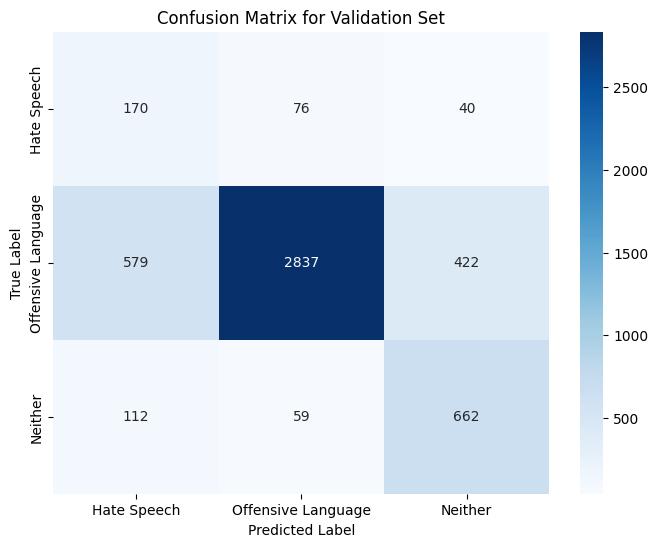

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Detailed Validation Set Evaluation ---\n")

# Get predictions for the entire validation dataset
val_predictions_probabilities = model.predict(val_dataset)
# Convert probabilities to predicted class indices
val_predicted_labels = np.argmax(val_predictions_probabilities, axis=1)

# We need the true labels from the validation dataset
# We can extract them by iterating through the dataset
true_val_labels_list = []
for _, labels_batch in val_dataset:
    true_val_labels_list.extend(labels_batch.numpy())
true_val_labels_array = np.array(true_val_labels_list)

# Ensure we have the correct number of labels (handle potential partial last batch)
val_predicted_labels = val_predicted_labels[:len(true_val_labels_array)]

# Original dataset mapping: 0: hate_speech, 1: offensive_language, 2: neither
class_names = [label_map[i] for i in sorted(label_map.keys())]

# 1. Classification Report (Precision, Recall, F1-score per class)
print("\nClassification Report:\n")
print(classification_report(true_val_labels_array, val_predicted_labels, target_names=class_names, digits=3)) # Added digits for more precision

# 2. Confusion Matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(true_val_labels_array, val_predicted_labels)
print(cm)

# Optional: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

***Note: Analysis of the evaluation metrics are in the report***